<a href="https://colab.research.google.com/github/alfeuduran/AzureMachineLearningTests/blob/master/Local_Machine_Fashion_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying Fashion-MNIST images

In this tutorial, you will be learning about how to classify the Fashion-MNIST dataset by building a simple convolutional neural network (CNN) in [Keras](https://keras.io/). Before  going into the details of model construction, let us learn a little bit more about our dataset: **Fashion-MNIST**. 

The Fashion MNISt dataset contains 70,000 grayscale images of fashion products from 10 different categories, there are 7,000 images per category. Each image is of size 28 x 28. The entire dataset is divided into two: a training set comprising of 60,000 images and the test set with 10,000 images. The data can be found here: https://github.com/zalandoresearch/fashion-mnist

## Step 1: Import the necessary modules

We are using here TensorFlow as backend for Keras. If you want to change the backend used in Keras from Tensorflow to CNTK you can do it by simply changing the `os.environ['KERAS_BACKEND']` variable to `cntk`

In [0]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 1.13.1
tensorflow


* We also import all the Keras functions we will need to use to create a Convolutional Neural Network (CNN)


In [0]:
#Fashion MNIST Dataset CNN model development: https://github.com/zalandoresearch/fashion-mnist
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
import matplotlib.pyplot as plt

## Step 2: Declare variables
* We setup some variables for example how many classes there are [0-9] as well as batch size to send the training sample of data in to the model and epochs is how many iterations/run thoroughs of the data there are
* Each image is of size 28 x 28 pixels

In [0]:
#no. of classes
num_classes = 10

# batch size and training iterations (epochs)
batch_size = 128
epochs = 24

#input image dimensions
img_rows,img_cols = 28,28

## Step 3: Load the dataset
* Now we load the dataset from the Keras Library. And explore the dataset. `x_train` and `x_test` are the training and test dataset features and `y_train` and `y_test` the respective labels. 

* We also plot one of the images from the training set with its corresponding text label.

#### You can change the img_index field to any number between 0 - 60000 to see different images

4423680/4422102 [==============================] - 1s 0us/step
(60000, 28, 28) train set
(10000, 28, 28) test set
Label Index: 9 Fashion Labels: Ankle boot


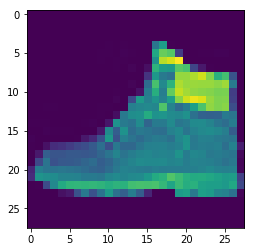

In [0]:
#data for train and testing
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print(x_train.shape, 'train set')
print(x_test.shape, 'test set')

# Define the text labels
fashion_mnist_labels = ["Top",          # index 0
                        "Trouser",      # index 1
                        "Jumper",       # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Trainer",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9

img_index=90
label_index = y_train[img_index]
plt.imshow(x_train[img_index])
print('Label Index: ' + str(label_index) + " Fashion Labels: " + (fashion_mnist_labels[label_index]))

## Step 4: Preprocess the dataset
* Now in step 4 we preprocess the images in both training and test dataset. The first step in preprocessing is **normalizing** the images, at present each pixel vale is a number between `1-255`, we divide it by 255 to ensure that the pixel values lie between `0-1`.  Normalization helps the model to converge as the math becomes easier with smaller numbers

* Also we need to [one-hot-encode](https://www.aimldl.org/ml/Recognizing_Handwritten_Digits.html#One-hot-encoding)
the labels, this converts them from numeric labels of `0-9` to binary vector of size 10.

* Lastly, since we are deadling with greyscale images we have a depth number = 1 that might be interpreted different dpending on how the images are treated in the framework used (CNTK, Tensorflow etc)

In [0]:
#type convert and scale the test and training data
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

#one-hot encoding
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test,  num_classes)

#formatting issues for depth of image (greyscale = 1) with different kernels (tensorflow, cntk, etc)
if K.image_data_format()== 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0],1,img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,1)
    x_test = x_test.reshape(x_test.shape[0],img_rows, img_cols,1)
    input_shape = (img_rows, img_cols,1)

## Step 5: Define Model Architecture

Now we use the Keras Sequential API to build a simple Convolutional Neural Network (CNN) layer by layer.

* We build  a **sequential model** meaning every layer passes information forward to the next layer of the network
* **1st Convoltuional Layer** - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **2nd pooling layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **3rd Convolutional Layer ** -we add a Convoltuional Layer - extracts features from data source, these are kernels/filters and feature maps. Feature maps passed to the  next layer. This layer also has a ReLu activation function - Y = max(0, x) this removes any value <0 and prevents vanishing gradients or weights <0
* **4th Pooling Layer ** - reduces dimensionality, reduce compute and helps with overfitting of the data.
* **5th/6th Dense fully connected layer with softmax function:** put features together and classify what item of clothing is used

> **Run some experiments to see how when you change the model below and rerun all the code the accuarcy and model will change:**
* add a dropout layer after the first pooling layer and also before the final dense layer: `model.add(Dropout(0.5))`
* change the value of dropout between 0 and 1: `model.add(Dropout(X))`
* change the 2 Conv2D layer first variable to 32 instead of 64: `model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))`
* Add padding to each of the Conv2D layers: `model.add(Conv2D(32, kernel_size=(3,3), padding = 'same', activation = 'relu'))`

In [0]:
#Define the CNN model
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

#model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               204928    
_________________________________________________________________
dens

## Step 6: Train and evaluate the model
* Now we compile the CNN model and assigns loss/optimiser functions as well as metrics we wish to view
* We also add a timer so we know how long the model takes to run
* Fit the training data to the model using 24 epoches and batches of 64 images. Pass in the test data as your validation set so we can see how the accuracy differs on the training set to the validation set as the model runs through 24 epochs
* Finally we evaluate the model using the test/validation set

> You can look at different optimisers available in Keras and see what happens when you change this value: [https://keras.io/optimizers/](https://keras.io/optimizers/)

In [0]:
#compile - how to measure loss
model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=['accuracy'])

#train the model and return loss and accuracy for each epoch - history dictionary
start = time.time()
hist = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_test, y_test))
end = time.time()

#evaluate the model on the test data
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])
print('Time to run: ', (end-start))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/24
60000/60000 [==============================] - 76s 1ms/step - loss: 0.5348 - acc: 0.8066 - val_loss: 0.3861 - val_acc: 0.8624
Epoch 2/24
60000/60000 [==============================] - 73s 1ms/step - loss: 0.3417 - acc: 0.8767 - val_loss: 0.3724 - val_acc: 0.8681
Epoch 3/24
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2977 - acc: 0.8916 - val_loss: 0.3077 - val_acc: 0.8888
Epoch 4/24
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2677 - acc: 0.9021 - val_loss: 0.2982 - val_acc: 0.8919
Epoch 5/24
60000/60000 [==============================] - 71s 1ms/step - loss: 0.2449 - acc: 0.9116 - val_loss: 0.2699 - val_acc: 0.9045
Epoch 6/24
60000/60000 [==============================] - 72s 1ms/step - loss: 0.2250 - acc: 0.9179 - val_loss: 0.2646 - val_acc: 0.9040
Epoch 7/24
60000/60000 [==============================] - 77s 1ms/step - loss: 0

* This code plots the training and validation accuracy across 24 epochs
* The training accuracy is often higher but the validation accuracy is deemed a more real world value
* In case you are not satisfied with your model, you can tune hyperparameter to get a better performance. The hyperparameters for this model being:
 * Batch Size
 * Epochs
 * Optimizer
 * Model Architecture

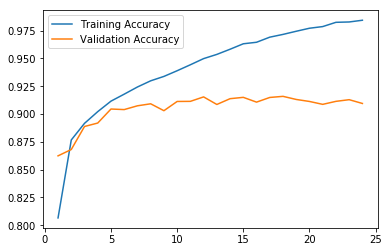

In [0]:
epoch_list = list(range(1, len(hist.history['acc']) + 1))
plt.plot(epoch_list, hist.history['acc'], epoch_list, hist.history['val_acc'])
plt.legend(('Training Accuracy', "Validation Accuracy"))
plt.show()

## Step 7: Test the model

Now we run this code to see a set of 15 images from the test set and whether the labels are assigned correctly. We made use of the code given in this [Medium post](https://medium.com/tensorflow/hello-deep-learning-fashion-mnist-with-keras-50fcff8cd74a) for visualization.

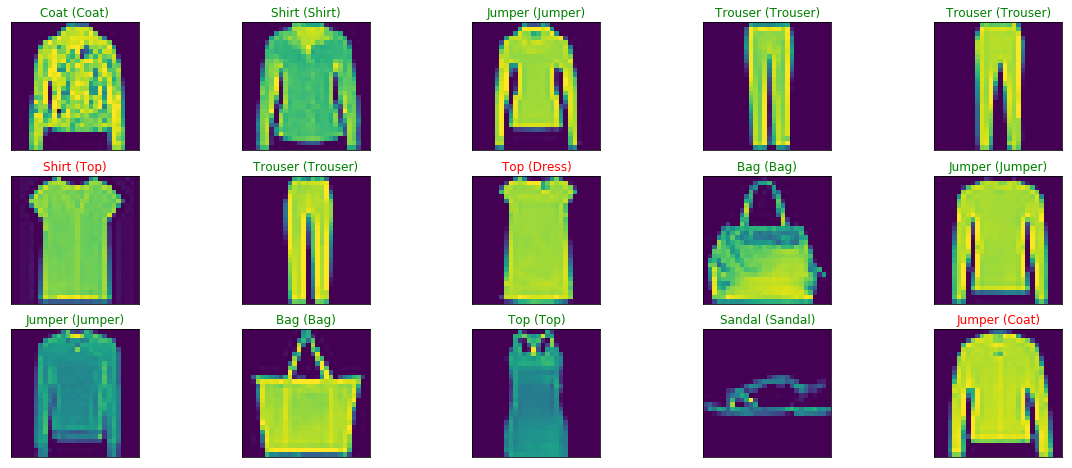

In [0]:
predictions = model.predict(x_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(predictions[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

### Congratulations you succesfully trained and evaluated the model on Fashion-MNIST dataset.